In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import platform
print(platform.python_version())

3.7.1


In [68]:
data = pd.read_csv("../dat/daily/rdt.csv")
data.shape

(320, 2)

In [5]:
data.reset_index()
data['ts'] = pd.to_datetime(data['ts'])
data['day'] = data['ts'].dt.weekday_name #this needs to become day_name() in new pandas/python
data['week_num'] = data['ts'].dt.week
data['year'] = data['ts'].dt.year
data['day_num'] = data['ts'].dt.dayofweek
data['day_num'] = (data['day_num'] + 5) % 7
data['new_week'] = 0
data.loc[data['day_num']==0, 'new_week'] = 1
data['new_week'] = data['new_week'].cumsum()
data.head(20)

,ts,rdt,day,week_num,year,day_num,new_week
0,2018-02-22,10,Thursday,8,2018,1,0
1,2018-02-23,10,Friday,8,2018,2,0
2,2018-02-24,10,Saturday,8,2018,3,0
3,2018-02-25,6,Sunday,8,2018,4,0
4,2018-02-26,0,Monday,9,2018,5,0
5,2018-02-27,8,Tuesday,9,2018,6,0
6,2018-02-28,10,Wednesday,9,2018,0,1
7,2018-03-01,6,Thursday,9,2018,1,1
8,2018-03-02,11,Friday,9,2018,2,1
9,2018-03-03,4,Saturday,9,2018,3,1


In [6]:
data_weekly = data.groupby('new_week').sum()
#data_weekly.reset_index()
#data_weekly = data_weekly.rename(columns={'week_num': 'week_num1', 'rdt': 'week_sum'})
data_weekly = data_weekly.reset_index()
data_weekly.head()


,new_week,rdt,week_num,year,day_num
0,0,44,50,12108,21
1,1,46,65,14126,21
2,2,45,72,14126,21
3,3,33,79,14126,21
4,4,35,86,14126,21


In [18]:
data_join = pd.merge(data, data_weekly.loc[:,:'rdt'], how='left', on='new_week')
data_join = data_join.rename(columns={'rdt_x':'tweets_d', 'rdt_y':'tweets_w'})
print(data_join.shape)
data_join.head(30)

(320, 8)


,ts,tweets_d,day,week_num,year,day_num,new_week,tweets_w
0,2018-02-22,10,Thursday,8,2018,1,0,44
1,2018-02-23,10,Friday,8,2018,2,0,44
2,2018-02-24,10,Saturday,8,2018,3,0,44
3,2018-02-25,6,Sunday,8,2018,4,0,44
4,2018-02-26,0,Monday,9,2018,5,0,44
5,2018-02-27,8,Tuesday,9,2018,6,0,44
6,2018-02-28,10,Wednesday,9,2018,0,1,46
7,2018-03-01,6,Thursday,9,2018,1,1,46
8,2018-03-02,11,Friday,9,2018,2,1,46
9,2018-03-03,4,Saturday,9,2018,3,1,46


In [26]:
idx = np.arange(6,320,7)
idx = np.insert(idx, 0, 0)
#idx
#data_join['tweets_w'].mean()
data_join.iloc[idx].tweets_w.mean()

69.54347826086956

In [12]:
data_join.iloc[data_join.shape[0]-1,6]

45

In [13]:
pd.unique(data_join.loc[data_join['tweets_w']>50,'new_week']).size

33

In [9]:
#calculate the empirical probability of writing more than x tweets
def calc_prob(df, x):
    weeks = df.iloc[df.shape[0]-1,6]
    x_weeks = pd.unique(df.loc[df['tweets_w']>x,'new_week']).size
    return x_weeks*1.0/weeks

In [10]:
calc_prob(data_join, 70)

0.5111111111111111

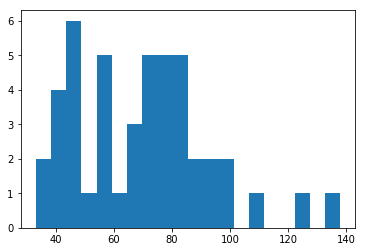

In [27]:
plt.hist(data_join.iloc[idx].tweets_w, bins=20)
plt.show()

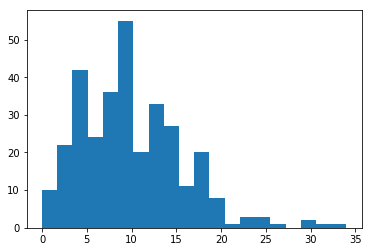

In [29]:
plt.hist(data_join["tweets_d"], bins=20)
plt.show()

As we can see from the above plot, there seems to be that the number of tweets per day could follow a Poisson distribution.

In [30]:
#given that we saw smaller than x number of tweets on first day, what is the probablity 
#to see larger than y and smaller than z on the end of the week, and also show how many instances smaller than x exist
#if the last variable is set to something else than 1 then evaluate the same but conditioned on seeing more than x
def calc_cond_prob(df, x, y, z, smaller):
    weeks_x = 0
    weeks_y = 0
    if smaller == 1:
        weeks_x = df[df['tweets_d']<x].loc[df['day']=='Wednesday','new_week'].size
        weeks_y = df[df['tweets_d']<x].loc[df['day']=='Wednesday',:].loc[df['tweets_w']>y,:].loc[df['tweets_w']<z,'new_week'].size
    else:
        weeks_x = df[df['tweets_d']>x].loc[df['day']=='Wednesday','new_week'].size
        weeks_y = df[df['tweets_d']>x].loc[df['day']=='Wednesday',:].loc[df['tweets_w']>y,:].loc[df['tweets_w']<z,'new_week'].size
    return weeks_y*1.0/weeks_x, weeks_x


In [31]:
#data_join[data_join['tweets_d']<5].loc[data_join['day']=='Wednesday',:].loc[data_join['tweets_w']>40,:].loc[data_join['tweets_w']<60,:]
data_join[data_join['tweets_d']<5].loc[data_join['day']=='Wednesday',:]

,ts,tweets_d,day,week_num,year,day_num,new_week,tweets_w
132,2018-07-04,4,Wednesday,27,2018,0,19,54
293,2018-12-12,3,Wednesday,50,2018,0,42,55
307,2018-12-26,1,Wednesday,52,2018,0,44,59
314,2019-01-02,3,Wednesday,1,2019,0,45,49


In [32]:
calc_cond_prob(data_join,7,30,50,1)

(0.625, 8)

# Linear Regression

Testing whether we can predict the weekly number of tweets based only on the number of tweets posted on Wednesday using simple linear regression

In [33]:
#linear model predicting the end of the week tweets based on firsr day
data_for_reg = data_join.loc[data_join['day']=='Wednesday',['tweets_d','tweets_w']]
X = data_for_reg['tweets_d'].values
y = data_for_reg['tweets_w'].values
X

array([10,  6, 10,  6,  9,  6, 11, 16,  7,  7,  8, 10, 17, 10, 18, 17, 16,
       17,  4, 16, 15, 15, 13, 10, 15, 13, 24, 15, 13,  9, 14, 16, 23, 23,
        7, 14, 14,  5, 13, 15,  9,  3, 12,  1,  3])

In [39]:
split = 0.8
trainX = X[:int(split*X.size)].reshape((int(split*X.size),1))
testX = X[int(split*X.size):].reshape((X.size - int(split*X.size),1))
trainY = y[:int(split*X.size)]
testY = y[int(split*X.size):]

In [40]:
mod = LinearRegression()
mod.fit(trainX,trainY)
preds = mod.predict(testX)

In [41]:
print('Coefficients: \n,', mod.coef_)
print('Intercept: \n', mod.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(testY, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testY, preds))

Coefficients: 
, [2.9473355]
Intercept: 
 34.450713034776065
Mean squared error: 163.41
Variance score: -0.05


In [46]:
MSE = np.power((preds - testY),2).mean()
RMSE = np.sqrt(MSE)
print("RMSE is %f" % RMSE)

RMSE is 12.783086


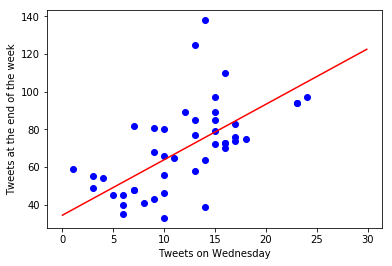

In [44]:
xspace = np.arange(0,30,0.1)
plt.plot(X,y,'bo')
plt.plot(xspace, mod.intercept_ + mod.coef_[0]*xspace, 'r-')
plt.xlabel('Tweets on Wednesday')
plt.ylabel('Tweets at the end of the week')
plt.show()

## Adding another predictor 

Testing the result after adding the rolling mean of the last 10 days to the model.

In [47]:
data_for_reg1 = data_join.loc[data_join['day']=='Wednesday',['tweets_d','daily_rolling_mean','tweets_w']].dropna()
X = data_for_reg1.loc[:,'tweets_d':'daily_rolling_mean'].values
y = data_for_reg1['tweets_w'].values

/Users/dvamvou/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [60]:
data_for_reg1 = data_join
data_for_reg1['rolling_mean_7'] = data_for_reg1['tweets_d'].rolling(7).mean()
data_for_reg1['rolling_mean_7'] = data_for_reg1['rolling_mean_7'].shift(1)
data_for_reg2 = data_for_reg1.loc[data_join['day']=='Wednesday',['tweets_d','rolling_mean_7','tweets_w']].dropna()
data_for_reg2

,tweets_d,rolling_mean_7,tweets_w
13,6,6.571429,45
20,10,6.428571,33
27,6,4.714286,35
34,9,5.000000,43
41,6,6.142857,40
48,11,5.714286,65
55,16,9.285714,73
62,7,10.428571,48
69,7,6.857143,48
76,8,6.857143,41


In [64]:
X = data_for_reg2[['tweets_d','rolling_mean_7']].values
y = data_for_reg2['tweets_w'].values
y

array([ 45,  33,  35,  43,  40,  65,  73,  48,  48,  41,  56,  76,  80,
        75,  83, 110,  74,  54,  70,  79,  97,  85,  66,  89,  77,  97,
        85, 125,  81,  39,  73,  94,  94,  82, 138,  64,  45,  58,  72,
        68,  55,  89,  59,  49])

In [65]:
split = 0.8
trainX = X[:int(split*X.shape[0]),:]
testX = X[int(split*X.shape[0]):,:]
trainY = y[:int(split*X.shape[0])]
testY = y[int(split*X.shape[0]):]
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(35, 2)
(9, 2)
(35,)
(9,)


In [73]:
mod1 = LinearRegression()
mod1.fit(trainX,trainY)
preds = mod1.predict(testX)

In [74]:
print('Coefficients: \n,', mod1.coef_)
print('Intercept: \n,', mod1.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(testY, preds))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testY, preds))

Coefficients: 
, [2.24291213 3.23453567]
Intercept: 
, 11.56872708477676
Mean squared error: 287.56
Variance score: -0.85


In [75]:
MSE = np.power((preds - testY),2).mean()
RMSE = np.sqrt(MSE)
print("RMSE is %f" % RMSE)

RMSE is 16.957738


In [90]:
preds = mod1.predict(trainX)
# Explained variance score: 1 is perfect prediction
print("Mean squared error: %.2f"
      % mean_squared_error(trainY, preds))
print('Variance score: %.2f' % r2_score(trainY, preds))

Mean squared error: 311.64
Variance score: 0.49


# Poisson Bayesian Regression

We want to model the daily tweets as a $Poisson(e^{[\alpha + b_1*tweets(t-1) + b_2*tweets(t-2)]})$ where we put normal priors on $\alpha, b_1, b_2$.

In [3]:
import pymc3 as pm
import patsy as pt

In [ ]:
data_join = data_join.rename(columns={'tweets_d': 'tweets1'})
data_join['tweets2'] = data_join['tweets1'].shift(1)
data_join['tweets3'] = data_join['tweets1'].shift(2)
data_join = data_join.dropna()
data_join.head()

In [120]:
for i in range (0,data_join.shape[0]):
    k = 6 - data_join.iloc[i,5] + 1
    data_join.iloc[i,8] = data_join.iloc[i:i+k,1].sum()
data_join.head(10)

,ts,tweets1,day,week_num,year,day_num,new_week,tweets_w,sum_till_tues,tweets2,tweets3
10,2018-03-04,1,Sunday,9,2018,4,1,46,15,4.0,11.0
11,2018-03-05,6,Monday,10,2018,5,1,46,14,1.0,4.0
12,2018-03-06,8,Tuesday,10,2018,6,1,46,8,6.0,1.0
13,2018-03-07,6,Wednesday,10,2018,0,2,45,45,8.0,6.0
14,2018-03-08,5,Thursday,10,2018,1,2,45,39,6.0,8.0
15,2018-03-09,5,Friday,10,2018,2,2,45,34,5.0,6.0
16,2018-03-10,10,Saturday,10,2018,3,2,45,29,5.0,5.0
17,2018-03-11,6,Sunday,10,2018,4,2,45,19,10.0,5.0
18,2018-03-12,6,Monday,11,2018,5,2,45,13,6.0,10.0
19,2018-03-13,7,Tuesday,11,2018,6,2,45,7,6.0,6.0


In [49]:
#define the model: tweets for a day are found based on the tweets of the last 2 days
fml = 'tweets1 ~ tweets2 + tweets3'
with pm.Model() as model:
    pm.glm.GLM.from_formula(fml, data_join, family=pm.glm.families.Poisson())
with model:
    trc_tweets = pm.sample(1000, tune=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, tweets3, tweets2, Intercept]
100%|██████████| 3000/3000 [00:09<00:00, 315.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [121]:
#get the posterior distributions of the parameters
stats = pm.summary(trc_tweets)
intr_mean = stats.loc['Intercept','mean']
b1_mean = stats.loc['tweets2','mean']
b2_mean = stats.loc['tweets3','mean']
intr_sd = stats.loc['Intercept','sd']
b1_sd = stats.loc['tweets2','sd']
b2_sd = stats.loc['tweets3','sd']
stats

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,1.948683,0.042851,0.001737,1.866459,2.037329
tweets2,0.020979,0.002939,0.000115,0.015322,0.026395
tweets3,0.013028,0.002919,0.000118,0.007082,0.018228
mu,49.358970,292.013985,9.889343,0.032440,134.624578


In [122]:
#function for getting samples from the posterior predictive distribution
#need to pass: tweets of the previous two days, means and standard deviations of parameters, number of samples
def create_samples(tweets1, tweets2, b1_mean, b2_mean, intercept_mean, b1_sd, b2_sd, intercept_sd, samples):
    if samples == 1:
        i = np.random.normal(intercept_mean, intercept_sd)
        b1 = np.random.normal(b1_mean, b1_sd)
        b2 = np.random.normal(b2_mean, b2_sd)
        theta = np.exp(i + b1 * tweets1 + b2 * tweets2)
        pred = np.random.poisson(theta)
        return pred
    else:
        i = np.random.normal(intercept_mean, intercept_sd, samples)
        b1 = np.random.normal(b1_mean, b1_sd, samples)
        b2 = np.random.normal(b2_mean, b2_sd, samples)
        theta = np.exp(i + b1 * tweets1 + b2 * tweets2)
        pred = np.random.poisson(theta)
        return pred


In [123]:
create_samples(10,10,0.003,0.001,2.28,0.005,0.005,0.06,100)

array([13, 12,  6, 13,  5,  8,  7, 11,  5, 10, 13, 18, 10,  7,  7,  9, 14,
       12, 14,  7, 10, 11, 12,  7,  6, 14,  8, 13,  7, 13, 12,  9,  9, 19,
       12,  8,  9,  6, 12,  8,  8,  3,  7,  9,  8,  5,  8, 10,  8,  7,  8,
        8, 15, 15, 12,  9,  9,  8, 11, 11,  8,  8, 10, 14,  7, 11,  6, 14,
        7,  9, 14, 15, 14, 12, 10,  5,  6, 11, 11,  8, 13,  9, 11,  7, 11,
       13, 10, 10, 12, 12, 11, 15, 10, 11, 11, 14,  7,  7,  7, 11])

In [124]:
create_samples(10,10,0.003,0.001,2.28,0.005,0.005,0.06,1)

15

## Simulating the future

Given the number of tweets in the previous two days, we now have the model to get a distribution of the number of tweets for today. However, our end goal is to predict this for the end of the week. What we can do is to propagate our prediction for today and simulate the next days which in turn depend ont he previous ones. Running a lot of simulations gives us many possible paths. Then we can estimate the probability of the sum of tweets in the end of the week based on the final point of these simulations. 

So we want to create a matrix whose rows indicate the evolution of tweets during the week and different columns indicate different simulations of this evolution.

In [125]:
def get_samples_matrix(tweets1, tweets2, b1_mean, b2_mean, intercept_mean, b1_sd, b2_sd, intercept_sd, samples, day):
    week = ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday']
    loops = len(week) - week.index(day) - 1
    #first row is the number of tweets for t-2
    tweets1_row = np.full((samples,), tweets1)
    #second row is the number of tweets from yesterday
    tweets2_row = np.full((samples,), tweets2)
    matrix = np.vstack((tweets1_row,tweets2_row))
    #third row comes from all different predictions based on posterior predictive
    preds = create_samples(tweets1, tweets2, b1_mean, b2_mean, intercept_mean, b1_sd, b2_sd, intercept_sd, samples)
    matrix = np.vstack((matrix,preds))
    #we run the prediction algorithm for the remaining days of the week
    for i in range(3, loops+3):
        preds = np.zeros(samples)
        matrix = np.vstack((matrix,preds))
        for j in range(samples):
            matrix[i][j] = create_samples(matrix[i-1][j], matrix[i-2][j], b1_mean, b2_mean, intercept_mean, b1_sd, b2_sd, intercept_sd, 1)
    return matrix

In [126]:
a = get_samples_matrix(10.0,10.0,0.003,0.001,2.28,0.005,0.005,0.06,10000,'Wednesday')
a.shape

(9, 10000)

In [129]:
def calc_prob(tweets1, tweets2, b1_mean, b2_mean, intercept_mean, b1_sd, b2_sd, intercept_sd, samples, day, bands, isprint):
    matrix = get_samples_matrix(tweets1, tweets2, b1_mean, b2_mean, intercept_mean, b1_sd, b2_sd, intercept_sd, samples, day)
    sums = np.sum(matrix[2:,:],axis=0)
    probs = []
    for i in range(0,len(bands)+1):
        if i==0:
            sums1 = sums[sums<bands[0]]
            prob = sums1.size/sums.size
            probs.append(prob)
            if isprint==1:
                print('The probability of seeing less than {} tweets is {}'.format(bands[0],prob))
        elif i==len(bands):
            sums1 = sums[sums>=bands[len(bands)-1]]
            prob = sums1.size/sums.size
            probs.append(prob)
            if isprint==1:
                print('The probability of seeing more than or equal to {} tweets is {}'.format(bands[len(bands)-1],prob))
        else:
            sums1 = sums[sums>=bands[i-1]]
            sums1 = sums1[sums1<bands[i]]
            prob = sums1.size/sums.size
            probs.append(prob)
            if isprint==1:
                print('The probability of seeing more than or equal to {} tweets and less than {} tweets is {}'.format(bands[i-1],bands[i],prob))
    return probs
            

In [133]:
calc_prob(data_join.iloc[2,9], data_join.iloc[2,10], b1_mean, b2_mean, intr_mean, b1_sd, b2_sd, intr_sd, samples, data_join.iloc[2,2], [5,10,20,30,40,50,60,70,80],0)


[0.0962, 0.6196, 0.2842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [134]:
def calc_expected(bands,probs):
    expec = np.zeros(len(probs))
    if len(bands) != len(probs)-1:
        print('Error: The length of bands must be equal to length of probabilities minus 1')
    else:
        for i in range(0,len(probs)):
            if i==0:
                expec[i] = np.mean(np.array([0.0,bands[0]]))*probs[0]
            elif i==len(probs)-1:
                expec[len(probs)-1] = np.mean(np.array([bands[len(bands)-1],120.0]))*probs[len(probs)-1]
            else:
                expec[i] = np.mean(np.array([bands[i-1],bands[i]]))*probs[i]
    return np.sum(expec)

In [144]:
df_backtest = data_join
df_backtest['expected'] = 0
df_backtest.head()

,ts,tweets1,day,week_num,year,day_num,new_week,tweets_w,sum_till_tues,tweets2,tweets3,expected
10,2018-03-04,1,Sunday,9,2018,4,1,46,15,4.0,11.0,0
11,2018-03-05,6,Monday,10,2018,5,1,46,14,1.0,4.0,0
12,2018-03-06,8,Tuesday,10,2018,6,1,46,8,6.0,1.0,0
13,2018-03-07,6,Wednesday,10,2018,0,2,45,45,8.0,6.0,0
14,2018-03-08,5,Thursday,10,2018,1,2,45,39,6.0,8.0,0


In [145]:
samples = 1000
for i in range(0,df_backtest.shape[0]):
    bands = [5,10,20,30,40,50,60,70,80]
    probs = calc_prob(df_backtest.iloc[i,9], df_backtest.iloc[i,10], b1_mean, b2_mean, intr_mean, b1_sd, b2_sd, intr_sd, samples, df_backtest.iloc[i,2], bands, 0)
    df_backtest.iloc[i,11] = calc_expected(bands,probs)
df_backtest.head(10)

,ts,tweets1,day,week_num,year,day_num,new_week,tweets_w,sum_till_tues,tweets2,tweets3,expected
10,2018-03-04,1,Sunday,9,2018,4,1,46,15,4.0,11.0,28.8700
11,2018-03-05,6,Monday,10,2018,5,1,46,14,1.0,4.0,16.7825
12,2018-03-06,8,Tuesday,10,2018,6,1,46,8,6.0,1.0,9.1675
13,2018-03-07,6,Wednesday,10,2018,0,2,45,45,8.0,6.0,69.1900
14,2018-03-08,5,Thursday,10,2018,1,2,45,39,6.0,8.0,57.9350
15,2018-03-09,5,Friday,10,2018,2,2,45,34,5.0,6.0,47.6750
16,2018-03-10,10,Saturday,10,2018,3,2,45,29,5.0,5.0,36.9700
17,2018-03-11,6,Sunday,10,2018,4,2,45,19,10.0,5.0,28.8300
18,2018-03-12,6,Monday,11,2018,5,2,45,13,6.0,10.0,19.2075
19,2018-03-13,7,Tuesday,11,2018,6,2,45,7,6.0,6.0,9.7100


In [147]:
df_backtest['diff'] = (df_backtest['expected'] - df_backtest['sum_till_tues']).abs()
df_backtest.head(50)

,ts,tweets1,day,week_num,year,day_num,new_week,tweets_w,sum_till_tues,tweets2,tweets3,expected,diff
10,2018-03-04,1,Sunday,9,2018,4,1,46,15,4.0,11.0,28.8700,13.8700
11,2018-03-05,6,Monday,10,2018,5,1,46,14,1.0,4.0,16.7825,2.7825
12,2018-03-06,8,Tuesday,10,2018,6,1,46,8,6.0,1.0,9.1675,1.1675
13,2018-03-07,6,Wednesday,10,2018,0,2,45,45,8.0,6.0,69.1900,24.1900
14,2018-03-08,5,Thursday,10,2018,1,2,45,39,6.0,8.0,57.9350,18.9350
15,2018-03-09,5,Friday,10,2018,2,2,45,34,5.0,6.0,47.6750,13.6750
16,2018-03-10,10,Saturday,10,2018,3,2,45,29,5.0,5.0,36.9700,7.9700
17,2018-03-11,6,Sunday,10,2018,4,2,45,19,10.0,5.0,28.8300,9.8300
18,2018-03-12,6,Monday,11,2018,5,2,45,13,6.0,10.0,19.2075,6.2075
19,2018-03-13,7,Tuesday,11,2018,6,2,45,7,6.0,6.0,9.7100,2.7100


In [149]:
df_backtest['diff'].mean()

10.50178225806451